### This Notebook is for exploring the IFG network
- plot bad IFGs
- perp baseline plots
- coherence matrix

In [1]:

#Import statements
import os
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import glob
import pandas as pd
import h5py

from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice

In [2]:
#Set up directories
track = 'T28'

work_dir = os.path.expanduser('/data/eme66/PROCESSDIR/EAR/{}/mintpy/'.format(track))
ifg_dir = os.path.expanduser('/data/eme66/PROCESSDIR/EAR/{}/merged/interferograms/'.format(track))

##### Plot the interferogram network

Now in work directory:  /data/eme66/PROCESSDIR/EAR/T28/mintpy/
read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 7
number of interferograms: 20
shift all perp baseline by -17.075042724609375 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 20
number of acquisitions marked as drop: 0
max perpendicular baseline: 312.23 m
max temporal      baseline: 60.0 days
showing coherence
data range: [0.3016, 0.8004]
display range: (0.2, 1.0)
showing ...


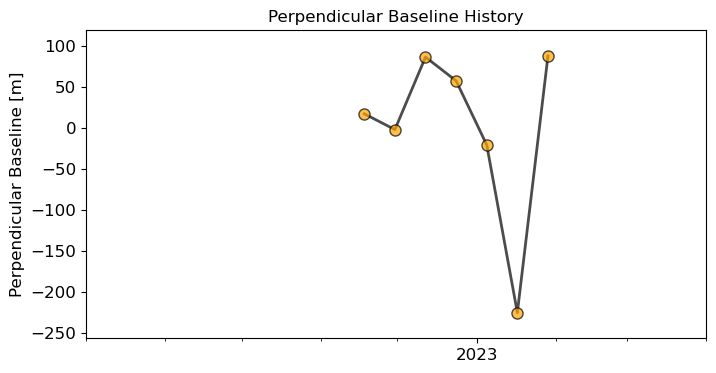

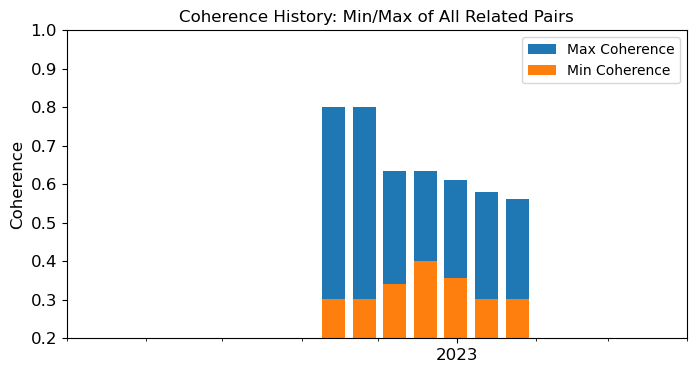

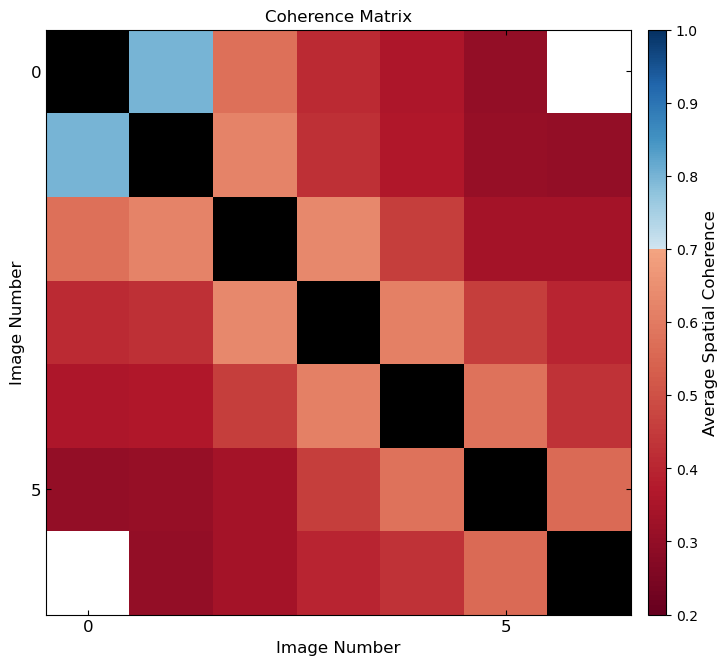

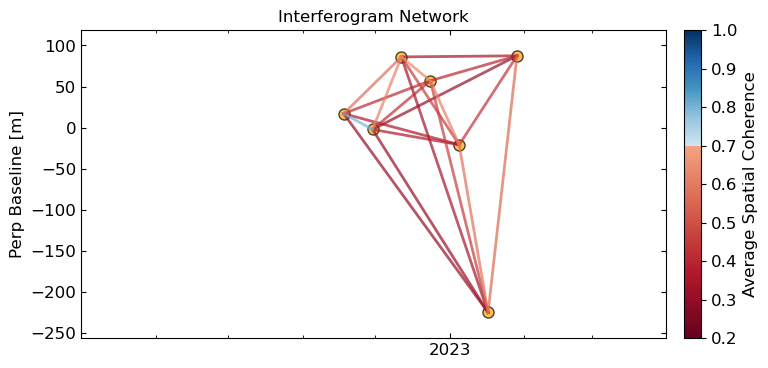

In [3]:
# Make sure you're in the right directory
os.chdir(work_dir)
print('Now in work directory: ', work_dir)

plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 8 4'.split())

In [4]:
# Make sure you're in the right directory
os.chdir(work_dir)
print('Now in work directory: ', work_dir)

# Print all IFGs with an average spatial coherence < threshold

cohth = 0.4 #coherence threshold - choose based on what makes sense

ifg_coh = pd.read_csv('coherenceSpatialAvg.txt', sep='\t', header=4, names=['Date', 'Mean', 'Btemp', 'Bperp', 'Num','NaN1', 'NaN2', 'Nan3']) #Idk why there are 3 columns of NaNs
bad_ifgs = ifg_coh.index[ifg_coh['Mean'] < cohth]
print('# IFGs below coherence threshold: ',len(bad_ifgs), 'out of', len(ifg_coh))

Now in work directory:  /data/eme66/PROCESSDIR/EAR/T28/mintpy/
# IFGs below coherence threshold:  7 out of 20


Now in IFG directory /data/eme66/PROCESSDIR/EAR/T28/merged/interferograms/


/home/eme66/mambaforge/envs/isce2gpu/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/eme66/mambaforge/envs/isce2gpu/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/eme66/mambaforge/envs/isce2gpu/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/eme66/mambaforge/envs/isce2gpu/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs.

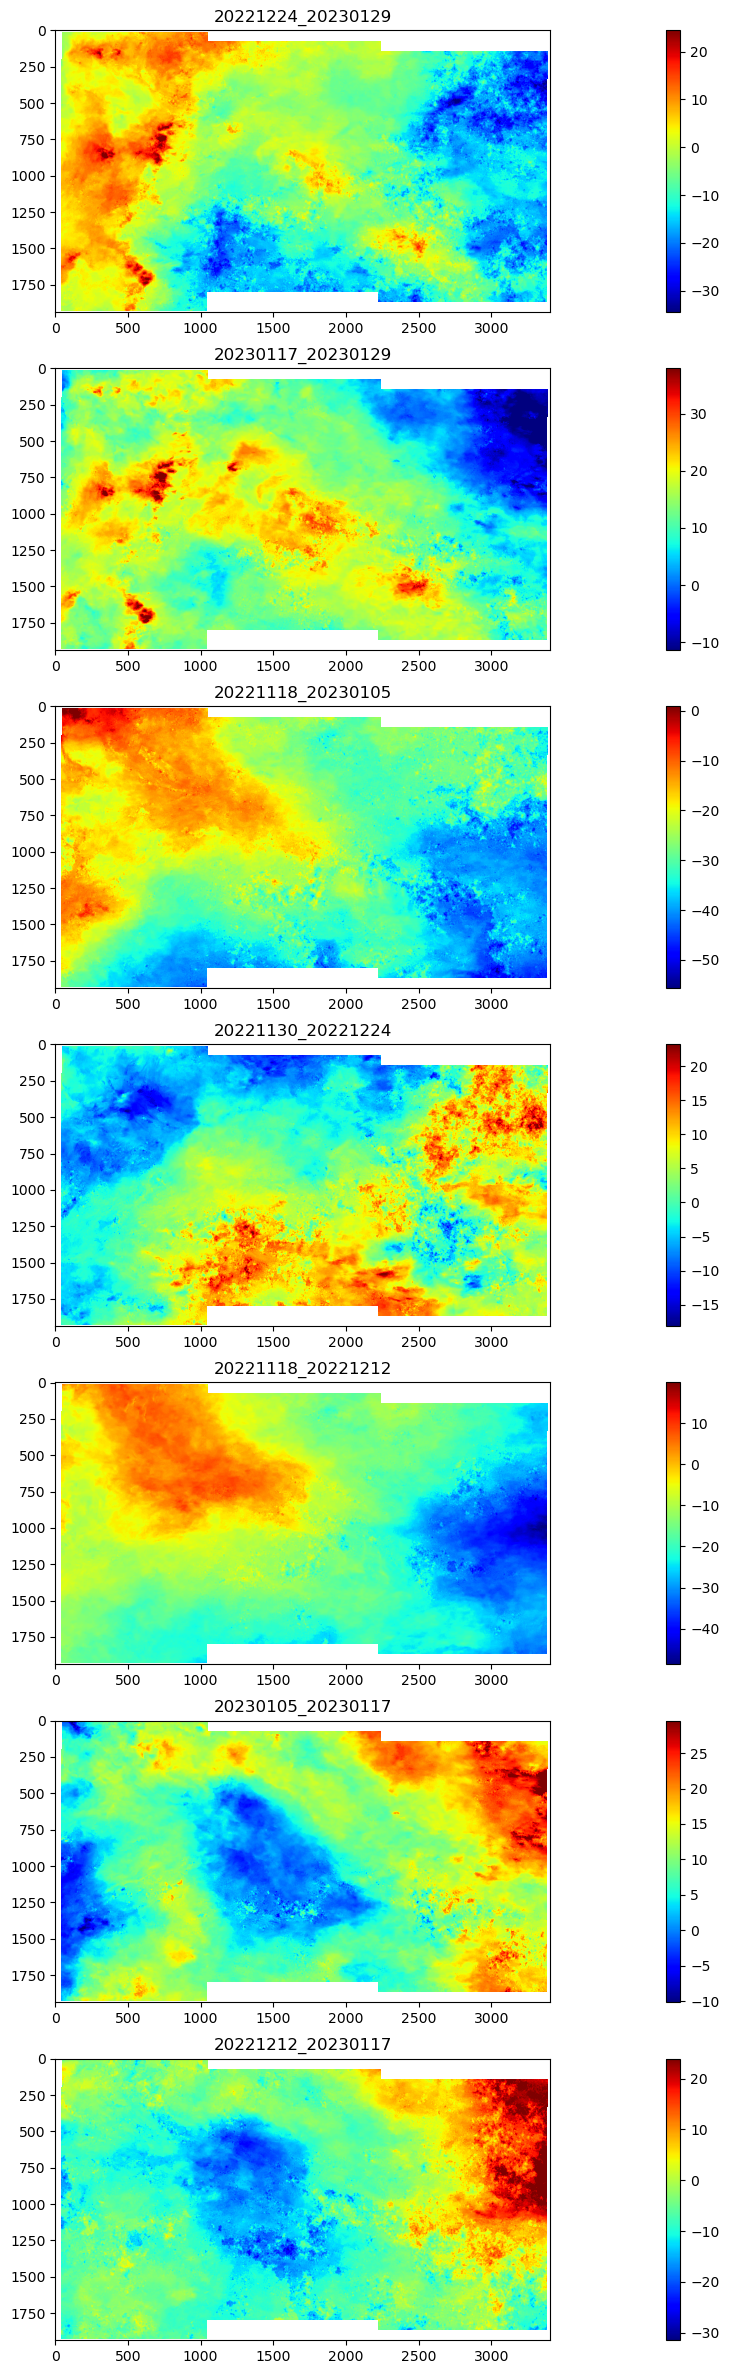

In [5]:
# Make sure in right directory
os.chdir(ifg_dir)
print('Now in IFG directory', ifg_dir)

# are stackSentinel products geocoded?
ifg_lst = glob.glob('*/filt_fine.unw')

# loop through? what is best way of doing this for 500+ IFGs - I think it's best to just look at the worst overall coherence ones

fig, axs = plt.subplots(len(bad_ifgs), figsize=(30,30))

for i, ele in enumerate(bad_ifgs):
    da = rioxr.open_rasterio(ifg_lst[ele])
    da['band'] = ['amplitude', 'phase']
    ds = da.to_dataset(dim='band')
    #amp = ds['amplitude'] #not plotting amplitude right now
    phs = ds['phase']
    phs = phs.where(phs !=0) #This step takes like 5 seconds per IFG!
    lower_bound = np.nanmean(phs) - 3*np.nanstd(phs)
    upper_bound = np.nanmean(phs) + 3*np.nanstd(phs)
    im = axs[i].imshow(phs, cmap='jet', vmin=lower_bound, vmax=upper_bound)
    fig.colorbar(im)
    axs[i].set_title(ifg_lst[ele].split('/')[0])


### Haven't done anything with ionosphere yet, you can skip this

In [6]:
# Exploring ionospheric corrections
ion = rioxr.open_rasterio('/data/eme66/PROCESSDIR/EAR/T28/ion/20221212_20230117/ion_cal/filt.ion')
ion['band'] = ['amplitude', 'phase']
ion_ds = ion.to_dataset(dim='band')
ion_amp = ion_ds['amplitude'] #not plotting amplitude right now
ion_phs = ion_ds['phase']

In [7]:
print(ion_phs.shape)
print(phs.shape)

(271, 340)
(1938, 3404)


### Deciding on a reference region
- plot average coherence across IFGs and stddev (don't have stddev yet)
- plot coherence for all IFGs (not currently doing this - probably not reasonable for full time series)


In [19]:
%matplotlib widget #you might need to do 'mamba install -c conda-forge ipympl' and restart VScode

UsageError: unrecognized arguments: #you might need to do 'mamba install -c conda-forge ipympl' and restart VScode


Now in work directory:  /data/eme66/PROCESSDIR/EAR/T28/mintpy/


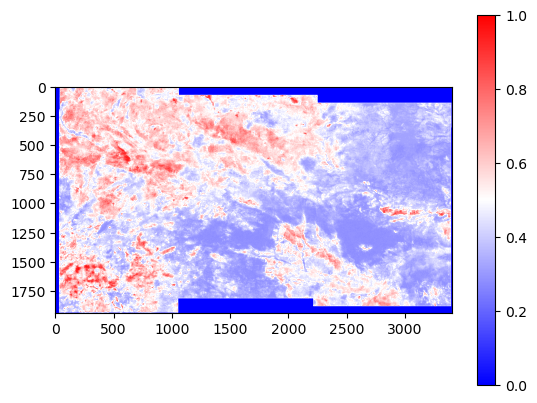

In [8]:
#Here we're just plotting the average coherence calculated for us

os.chdir(work_dir)
print('Now in work directory: ', work_dir)

fin = h5py.File('avgSpatialCoh.h5')
coh = np.array(fin['coherence'])
plt.imshow(coh, cmap='bwr')
plt.colorbar()

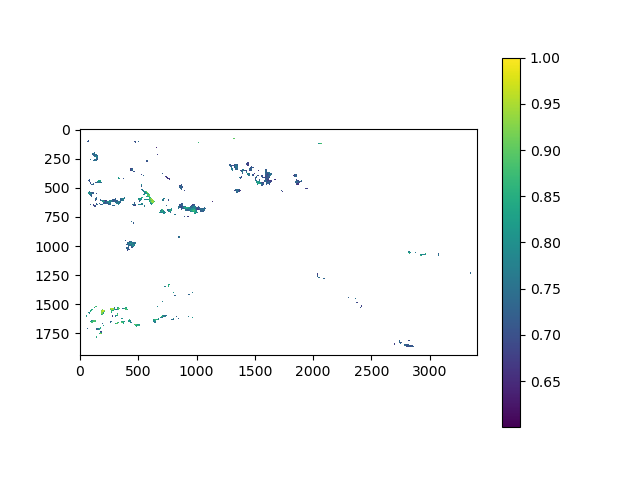

In [10]:
# We want a closer look at the highest areas of coherence - my data is pretty bad so I had to use a threshold of 0.6 to see anything
# Ideally we would have somewhere closer to 0.8 or 0.9

mask = np.ma.masked_where(coh<0.6, coh) #shows where we have "high" coherence
plt.imshow(mask)
plt.colorbar()
plt.show()

# Use the box looking tool above the save icon to zoom in on a region that has high coherence to pick your reference pixel

In [11]:
from mintpy.cli import view, tsview, plot_network, plot_transection

tsview.py timeseries_ERA5_ramp_demErr.h5 --lalo -9.592 34.585 --ref-yx 610 610 --figsize 9 3 --ref-date 20221118
open timeseries file: timeseries_ERA5_ramp_demErr.h5
data   coverage in y/x: (0, 0, 3404, 1938)
subset coverage in y/x: (0, 0, 3404, 1938)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
ASCENDING orbit -> flip up-down
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file timeseries_ERA5_ramp_demErr.h5
reference to pixel: [610, 610]
reference to date: 20221118
read mask from file: maskTempCoh.h5
data    range: [-12.104474, 14.611151] cm
display range: [-11.293626, 13.180511] cm
create figure for map in size of [10.0, 5.2]
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting Data ...
plot reference point
plot points of inter

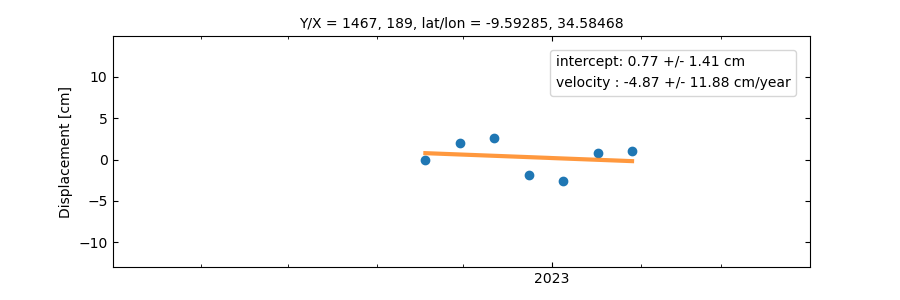

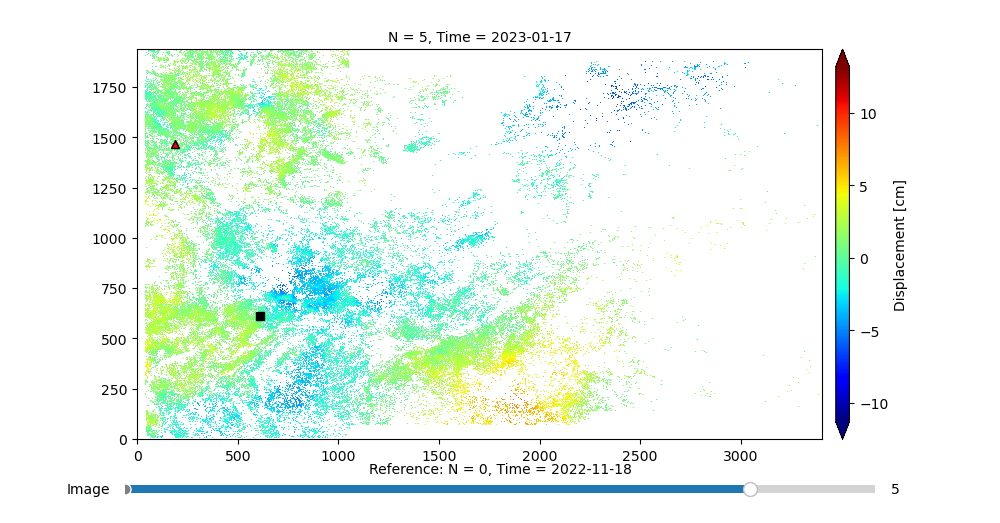

In [18]:
ts_file = os.path.expanduser('timeseries_ERA5_ramp_demErr.h5')
# lalo is the coordinates for the GNSS station MATL. ref-yx is the new reference point based on high coherence
cmd = f'{ts_file} --lalo -9.592 34.585 --ref-yx 610 610 --figsize 9 3 --ref-date 20221118 ' # need to change ref-date, maybe ref-yx based on what you find
tsview.main(cmd.split())
